In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
excel_file_path="C:\\Users\\POOJA\\OneDrive\\Documents\\hubble_1.xlsx"
data=pd.read_excel(excel_file_path)
print(data)

         z   H(z)  Error on H(z)
0   0.0700   69.0           19.6
1   0.0900   69.0           12.0
2   0.1200   68.6           26.2
3   0.1700   83.0            8.0
4   0.1790   75.0            4.0
5   0.1990   75.0            5.0
6   0.2000   72.9           29.6
7   0.2700   77.0           14.0
8   0.2800   88.8           36.6
9   0.3520   83.0           14.0
10  0.3802   83.0           13.5
11  0.4000   95.0           17.0
12  0.4004   77.0           10.2
13  0.4247   87.1           11.2
14  0.4497   92.8           12.9
15  0.4700   89.0           50.0
16  0.4783   80.9            9.0
17  0.4800   97.0           62.0
18  0.5930  104.0           13.0
19  0.6800   92.0            8.0
20  0.7500   98.8           33.6
21  0.7810  105.0           12.0
22  0.8750  125.0           17.0
23  0.8800   90.0           40.0
24  0.9000  117.0           23.0
25  1.0370  154.0           20.0
26  1.3000  168.0           17.0
27  1.3630  160.0           33.6
28  1.4300  177.0           18.0
29  1.5300

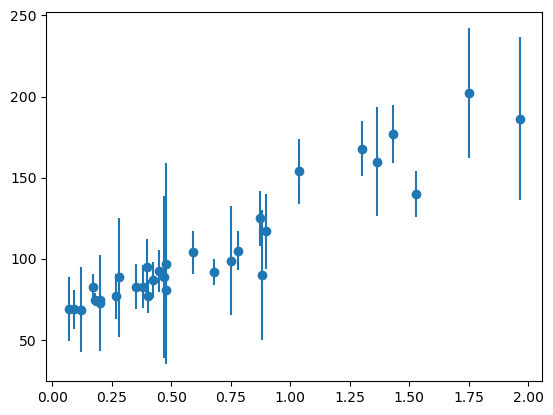

In [3]:
z=np.array(data['z'])  #df['z'] this is panda series
H=np.array(data['H(z)'])
e=np.array(data['Error on H(z)'])
plt.errorbar(z,H,yerr=e,fmt='o')
plt.show()

In [4]:
def polynomial_fit(theta, z):
    return sum(t * z ** n for (n, t) in enumerate(theta))

In [5]:
from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    x=z
    y=H
    sigma_y=e
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

In [6]:
from scipy import optimize

def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta1 = best_theta(1)
theta2 = best_theta(2)
theta3 = best_theta(3)

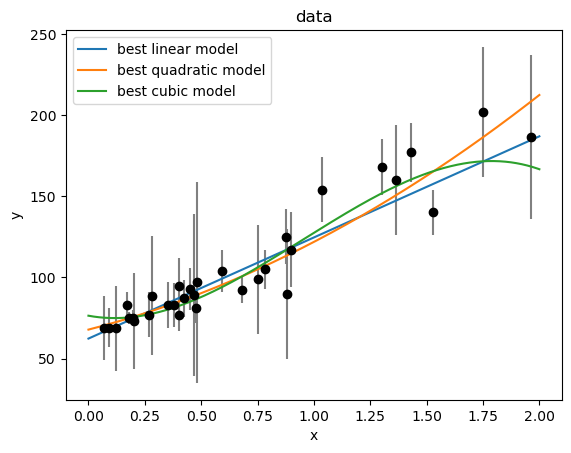

In [7]:
xfit = np.linspace(0, 2, 1000)
fig, ax = plt.subplots()
ax.errorbar(z, H, e, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.legend(loc='best', fontsize=10)
ax.set(xlabel='x', ylabel='y', title='data');

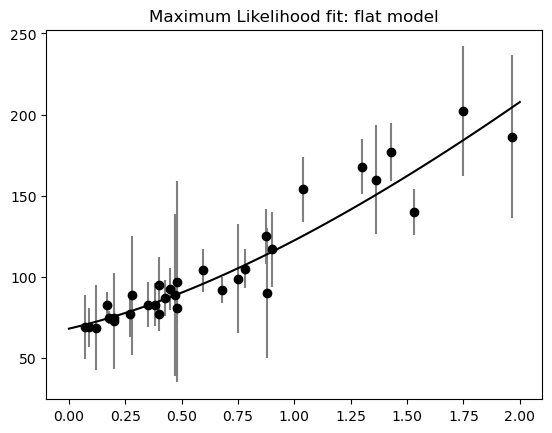

In [8]:
from scipy import optimize

def squared_loss(params, z=z, H=H, e=e):
    Omega_M=params[0]
    H_o=params[1]
    th=(Omega_M * (1 + z)**3 )+ 1 - Omega_M
    H_th=H_o * np.sqrt(th)
    dH = (H_th-H)
    return np.sum((dH / e) ** 2)
result = optimize.fmin(squared_loss, [0.05,65], disp=False)
Omega_M=result[0]
H_o=result[1]
xfit = np.linspace(0, 2, 100)
H_th_flat=H_o* np.sqrt(Omega_M * (1 + xfit)**3 + 1 - Omega_M)
plt.errorbar(z, H, e, fmt='ok', ecolor='gray')
plt.plot(xfit, H_th_flat , '-k')
plt.title('Maximum Likelihood fit: flat model');

In [9]:
print(Omega_M)

0.31900981639977904


In [10]:
print(H_o)

68.15225156382964


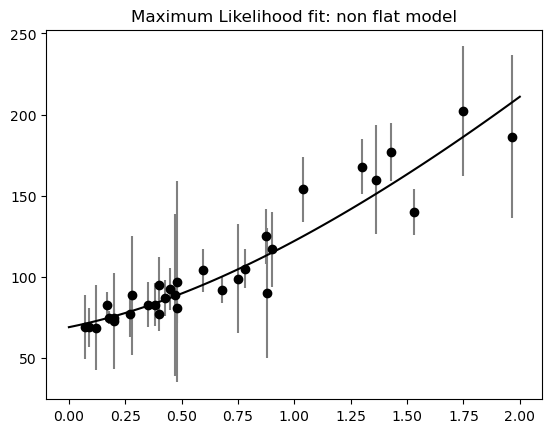

In [11]:

def squared_loss_non_flat(params, z=z, H=H, e=e):
    Omega_M=params[0]
    H_o=params[1]
    Omega_k=params[2]
    th=(Omega_M * (1 + z)**3 )+(Omega_k * (1 + z)**2 )+ 1 - Omega_M- Omega_k
    H_th=H_o * np.sqrt(th)
    dH = (H_th-H)
    return np.sum((dH / e) ** 2)
res= optimize.fmin(squared_loss_non_flat, [0.05, 30,0.1], disp=False)
Omega_M=res[0]
H_o=res[1]
Omega_k=res[2]
xfit = np.linspace(0, 2, 100)
H_th_1=H_o* np.sqrt((Omega_M * (1 + xfit)**3 )+(Omega_k * (1 + xfit)**2 )+ 1 - Omega_M- Omega_k)
plt.errorbar(z, H, e, fmt='ok', ecolor='gray')
plt.plot(xfit, H_th_1 , '-k')
plt.title('Maximum Likelihood fit: non flat model');

In [12]:
print(H_o)

69.06919381573638


In [13]:
print(Omega_k)

-0.13581301831445214


In [14]:
print(Omega_M)

0.36241950676531076


In [15]:
def flat_model(params,z):
    Omega_M=params[0]
    H_o=params[1]
    th=(Omega_M * (1 + z)**3 )+ 1 - Omega_M
    H_th=H_o * np.sqrt(th)
    return H_th

In [16]:
from scipy import stats
def flat_logL(params, model=flat_model, z=z, H=H, e=e):
    H_fit = flat_model(params, z)
    return np.sum(stats.norm.logpdf(H, H_fit, e))
def best_param(model, z=z, H=H, e=e):
    param_0 = [0.1,65]
    neg_logL = lambda params: -flat_logL(params, model,z,H,e)
    return optimize.fmin_bfgs(neg_logL, param_0, disp=False)

In [17]:
def AIC(z,H,e,model=flat_model):
    params = best_param(flat_model)
    Lmax = flat_logL(params, model,z=z, H=H, e=e)
    k = 2
    return -2 * Lmax + 2 * k,params
AIC_ ,params= AIC(z,H,e)
print("AIC :", AIC_)
print(params)

AIC : 260.9872437588849
[ 0.31900865 68.15230444]


In [18]:
def flat_BIC(z, H, e, model=flat_model):
    params = best_param(model)
    L_max = flat_logL(params, model, z=z, H=H, e=e)

    k = len(params)  
    N = len(z)  
    BIC_val = -2 * L_max + k * np.log(N)
    
    return BIC_val, params

BIC_val, params = flat_BIC(z, H, e)
print("BIC:", BIC_val)
print(params)

BIC: 263.9187155644844
[ 0.31900865 68.15230444]


In [19]:
def non_flat_model(params,z):
    Omega_M=params[0]
    H_o=params[1]
    Omega_k=params[2]
    th=(Omega_M * (1 + z)**3 )+(Omega_k * (1 + z)**2 )+ 1 - Omega_M- Omega_k
    H_th=H_o * np.sqrt(th)
    return H_th

In [20]:
def non_flat_logL(params, model=non_flat_model, z=z, H=H, e=e):
    H_fit = non_flat_model(params, z)
    return sum(stats.norm.logpdf(*args)
               for args in zip(H, H_fit,e))

def best_param_non_flat(model, z=z, H=H, e=e):
    param_0 = [0.1,65,0.01]
    neg_logL = lambda params: -non_flat_logL(params, model,z,H,e)
    return optimize.fmin_bfgs(neg_logL, param_0, disp=False)

In [21]:
def AIC(z,H,e,model=non_flat_model):
    params = optimize.fmin(squared_loss_non_flat, [0.05, 30,-0.1], disp=False)
    Lmax = non_flat_logL(params, model,z,H,e)
    k = 3
    return -2 * Lmax + 2 * k,params
AIC_ ,params= AIC(z,H,e)
print("AIC :", AIC_)
print(params)


AIC : 262.9422236785076
[ 0.36242243 69.06924719 -0.13582071]


In [22]:
def non_flat_BIC(z, H, e, model=non_flat_model):
    params = optimize.fmin(squared_loss_non_flat, [0.05, 30,-0.1], disp=False)
    L_max = non_flat_logL(params, model, z=z, H=H, e=e)

    k = 3  
    N = len(z)  
    BIC_val = -2 * L_max + k * np.log(N)
    
    return BIC_val, params

BIC_val, params = non_flat_BIC(z, H, e)
print("BIC:", BIC_val)
print(params)

BIC: 267.33943138690677
[ 0.36242243 69.06924719 -0.13582071]


C:\Users\POOJA\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Text(0.5, 1.0, 'Parameter Space (Flat ΛCDM)')

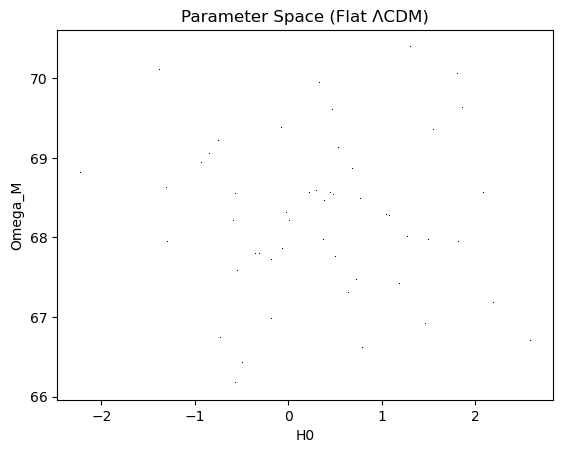

In [23]:
import emcee

def log_prior_flat(params):
    H0, Omega_M = params
    if 0 < H0 < 100 and 0 < Omega_M < 1:
        return 0
    return -np.inf  # log(0) = -inf
def log_likelihood_flat(params, z, H, e):
    H0, Omega_M = params
    Hth = H0 * np.sqrt(Omega_M * (1 + z)**3 + 1 - Omega_M)
    return -0.5 * np.sum(((Hth - H) / e)**2)
def log_posterior_flat(params, z, H, e):
    return log_prior_flat(params) + log_likelihood_flat(params, z, H, e)

ndim_flat = 2
nwalkers_flat = 50
nburn_flat = 1000
nsteps_flat = 5000

np.random.seed(0)
starting_guesses = np.zeros((nwalkers_flat, ndim_flat))
starting_guesses[:, :2] = np.random.normal(result, 1, (nwalkers_flat, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers_flat, ndim_flat - 2))

sampler_flat = emcee.EnsembleSampler(nwalkers_flat, ndim_flat, log_posterior_flat, args=[z, H, e])
sampler_flat.run_mcmc(starting_guesses, nsteps_flat)
samples_flat = sampler_flat.chain[:, nburn_flat:, :].reshape(-1, ndim_flat)

param_res = np.mean(samples_flat[:, :2], 0)

plt.plot(samples_flat[:, 0], samples_flat[:, 1], ',k', alpha=0.1)
plt.xlabel('H0')
plt.ylabel('Omega_M')
plt.title('Parameter Space (Flat ΛCDM)')



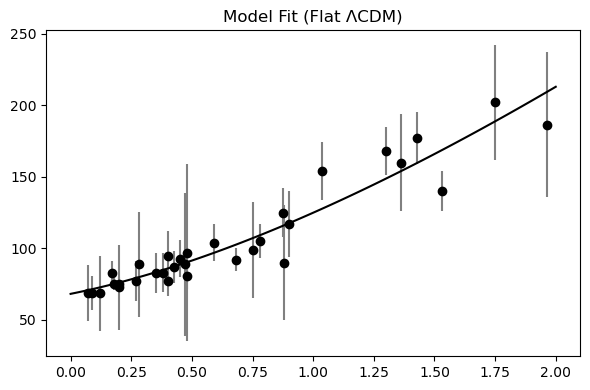

In [24]:
Omega_M=param_res[0]
H_o=param_res[1]
xfit = np.linspace(0, 2, 100)
plt.figure(figsize=(6, 4))
H_th_flat=H_o* np.sqrt(Omega_M * (1 + xfit)**3 + 1 - Omega_M)
plt.errorbar(z, H, e, fmt='ok', ecolor='gray')
plt.plot(xfit, H_th_flat , '-k')
plt.title('Model Fit (Flat ΛCDM)')

plt.tight_layout()
plt.show()

In [25]:
print("Omega_M:",Omega_M)
print("H_o:",H_o)

Omega_M: 0.3358159797771555
H_o: 68.25506143153854


In [26]:
flat_std_dev = np.std(samples_flat[:,:2], axis=0)
print(flat_std_dev)

[1.02967378 0.98373107]


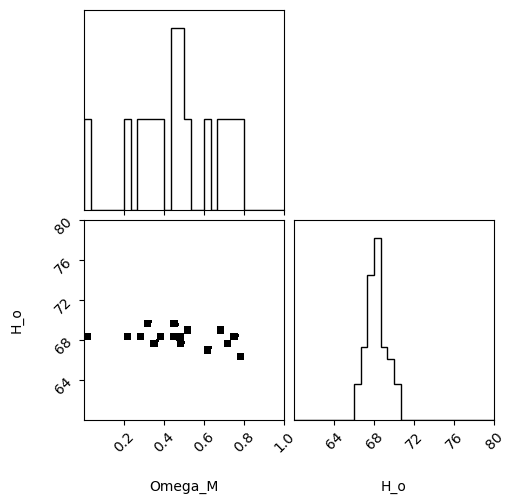

In [27]:
import corner
labels = ["Omega_M", "H_o"]
samples_flat = sampler_flat.chain[:, nburn_flat:, :].reshape(-1, ndim_flat)
fig = corner.corner(
    samples_flat,labels=labels,
    bins=30,range=[(0, 1), (60, 80)]
)

In [32]:
import emcee

def log_prior_non_flat(params):
    H0, Omega_M ,Omega_k= params
    if 0 < H0 < 100 and 0 < Omega_M < 1 and -1 < Omega_k < 0:
        return 0
    return -np.inf 
def log_likelihood_non_flat(params, z, H, e):
    H0, Omega_M,Omega_k= params
    H_th=(Omega_M * (1 + z)**3 )+(Omega_k * (1 + z)**2 )+ 1 - Omega_M- Omega_k
    return -0.5 * np.sum(((H_th - H) / e)**2)
def log_posterior_non_flat(params, z, H, e):
    return log_prior_non_flat(params) + log_likelihood_non_flat(params, z, H, e)
ndim_non_flat = 3
nwalkers_non_flat = 50
nburn_non_flat = 1000
nsteps_non_flat = 5000

np.random.seed(0)
starting_guesses = np.zeros((nwalkers_non_flat, ndim_non_flat))
starting_guesses[:, :3] = np.random.normal(res, 1, (nwalkers_non_flat, 3))
starting_guesses[:, 3:] = np.random.normal(0.5, 0.1, (nwalkers_non_flat, ndim_non_flat - 2))

sampler_non_flat = emcee.EnsembleSampler(nwalkers_non_flat, ndim_non_flat, log_posterior_non_flat, args=[z, H, e])
sampler_non_flat.run_mcmc(starting_guesses, nsteps_non_flat)
samples_non_flat = sampler_non_flat.chain[:, nburn_non_flat:, :].reshape(-1, ndim_non_flat)

param_res = np.mean(samples_non_flat[:, :3], 0)

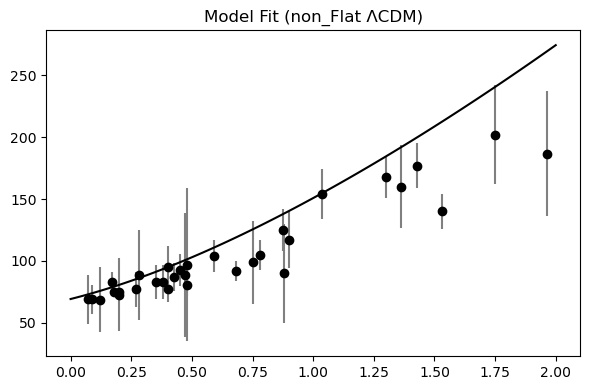

In [33]:
param_res = np.mean(samples_non_flat[:, :3], 0)
Omega_M=param_res[0]
H_o=param_res[1]
Omega_k=param_res[2]
xfit = np.linspace(0, 2, 100)
plt.figure(figsize=(6, 4))
H_th_flat=H_o* np.sqrt((Omega_M * (1 + xfit)**3 )+(Omega_k * (1 + xfit)**2 )+ 1 - Omega_M- Omega_k)
plt.errorbar(z, H, e, fmt='ok', ecolor='gray')
plt.plot(xfit, H_th_flat , '-k')
plt.title('Model Fit (non_Flat ΛCDM)')

plt.tight_layout()
plt.show()

In [34]:
print("Omega_M:",Omega_M)
print("H_o:",H_o)
print("Omega_k:",Omega_k)

Omega_M: 0.6417740450360405
H_o: 69.28127257910143
Omega_k: -0.2510954486499323


In [35]:
non_flat_std_dev = np.std(samples_non_flat[:,:3], axis=0)
print(non_flat_std_dev)

[1.05785981 1.00163474 0.95462577]


In [36]:
non_flat_samples = sampler_non_flat.get_chain(discard=100, thin=15, flat=True)
print(non_flat_samples.shape)

(16300, 3)


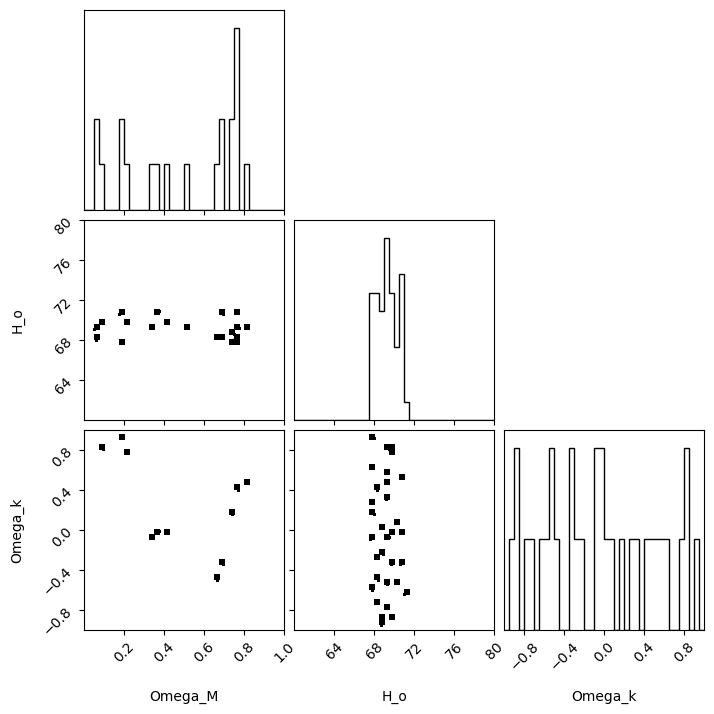

In [37]:
import corner
labels = ["Omega_M", "H_o", "Omega_k"]
samples_non_flat = sampler_non_flat.chain[:, nburn_non_flat:, :].reshape(-1, ndim_non_flat)
fig = corner.corner(
    samples_non_flat,labels=labels,
    bins=40,range=[(0, 1), (60, 80),(-1,1)]
)

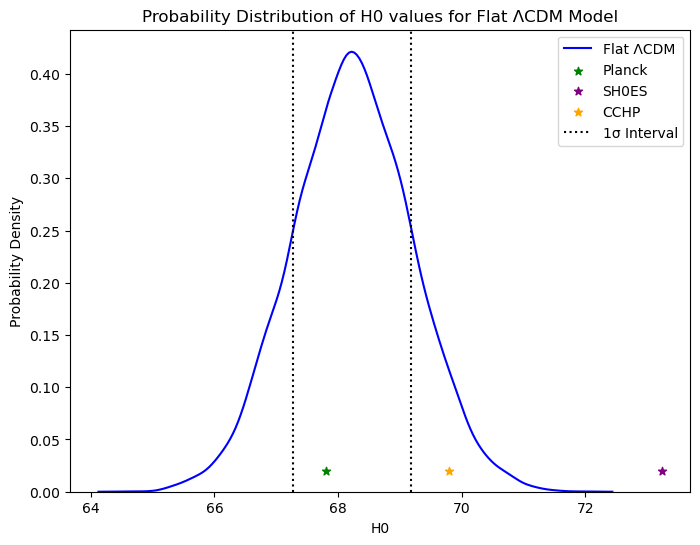

In [38]:
import seaborn as sns
samples_flat = np.random.normal(68.25,0.98, 10000)

conf_interval_flat = np.percentile(samples_flat, [16, 84])

plt.figure(figsize=(8, 6))
sns.kdeplot(samples_flat, color='blue', label='Flat ΛCDM')
plt.scatter(67.8,0.02, color='green', marker='*', label='Planck')
plt.scatter(73.24,0.02, color='purple', marker='*', label='SH0ES')
plt.scatter(69.8,0.02, color='orange', marker='*', label='CCHP')

plt.axvline(conf_interval_flat[0], color='black', linestyle=':', label='1σ Interval')
plt.axvline(conf_interval_flat[1], color='black', linestyle=':')

plt.xlabel('H0')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of H0 values for Flat ΛCDM Model')
plt.legend()
plt.show()

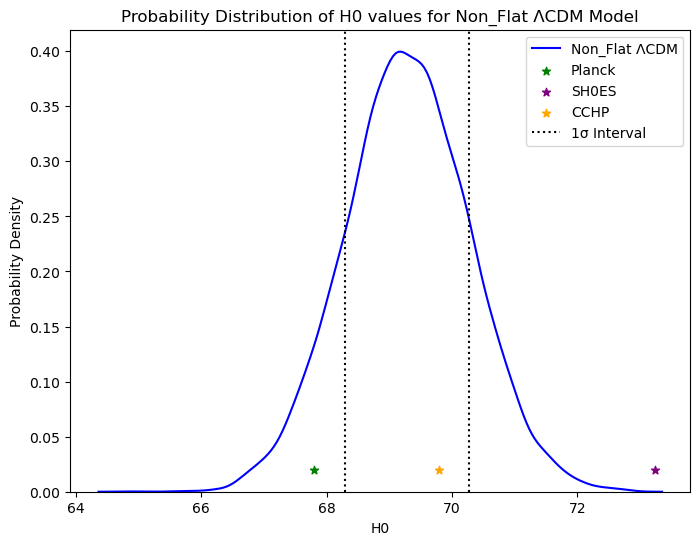

In [39]:
import seaborn as sns
samples_non_flat = np.random.normal(69.28,1, 10000)

conf_interval_non_flat = np.percentile(samples_non_flat, [16, 84])

plt.figure(figsize=(8, 6))

sns.kdeplot(samples_non_flat, color='blue', label='Non_Flat ΛCDM')

plt.scatter(67.8,0.02, color='green', marker='*', label='Planck')
plt.scatter(73.24,0.02, color='purple', marker='*', label='SH0ES')
plt.scatter(69.8,0.02, color='orange', marker='*', label='CCHP')

plt.axvline(conf_interval_non_flat[0], color='black', linestyle=':', label='1σ Interval')
plt.axvline(conf_interval_non_flat[1], color='black', linestyle=':')

plt.xlabel('H0')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of H0 values for Non_Flat ΛCDM Model')
plt.legend()
plt.show()